In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import math
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
# plt.rcParams["figure.figsize"] = 12.8, 9.6

In [478]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [479]:
!ls "/content/gdrive/My Drive/Colab Notebooks/orientation"

18-march  20-march	    box_1_output.npy  box_3_output.npy
19-march  box_0_output.npy  box_2_output.npy  box_4_output.npy


In [0]:
def load_point_cloud_from_file():
  df = np.load("/content/gdrive/My Drive/Colab Notebooks/orientation/20-march/30/point_cloud_err_1.npy")
  return df.T

In [0]:
def scale_input_data(point_list, scale_factor):
  return point_list*scale_factor

In [0]:
def filter_input_data_for_outliers(points, remove_width_outliers=False):
  # remove depth values that are out of bound
  points[2] = points[2]*DEPTH_SCALE
  depth_std_dev = np.std(points[2])
  depth_mean = np.mean(points[2])
  width_std_dev = np.std(points[0])
  width_mean = np.mean(points[0])

  print("depth standard deviation = ", depth_std_dev)
  print("depth mean = ", depth_mean)

  print("width standard deviation = ", width_std_dev)
  print("width mean = ", width_mean)

  filtered_array = np.array([])
  for index in range(len(points[2])):
    depth_outlier_flag = True
    width_outlier_flag = False
    if points[2][index] < (depth_mean + depth_std_dev) and points[2][index] > (depth_mean - depth_std_dev):
      depth_outlier_flag = False
    else:
      depth_outlier_flag = True
    
    if remove_width_outliers:
      if points[0][index] < (width_mean + width_std_dev*2) and points[0][index] > (width_mean - width_std_dev*2):
        width_outlier_flag = False
      else:
        width_outlier_flag = True
    
    if depth_outlier_flag == False and width_outlier_flag == False:
      filtered_array = np.append(filtered_array, points[:, index], axis=0)
  
  # print("flat array length = ", len(filtered_array)/3)
  filtered_array = np.reshape(filtered_array, (int(len(filtered_array)/3), 3))
  return filtered_array.T

In [0]:
def apply_standard_scaling(points):
  scaler = StandardScaler()
  X = scaler.fit_transform(points)
  return X

In [0]:
def remove_minor_clusters(filtered_points, num_cluster=3, cut_off_scale_factor=1):
  cluster_points = [(filtered_points[0][index], filtered_points[2][index]) for index in range(len(filtered_points[0]))]
  scaler = StandardScaler()
  X = scaler.fit_transform(cluster_points)
  kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(X)
  # print(kmeans.labels_)

  data = {"x": filtered_points[0], "y": filtered_points[1], "depth": filtered_points[2], "cluster": kmeans.labels_}
  df = pd.DataFrame(data)
  mean = df.groupby('cluster').count().mean()['depth']
  cluster_depth = df.groupby('cluster').count()['depth']
  cluster_depth = cluster_depth.where(cluster_depth > mean*cut_off_scale_factor).dropna()
  # print(cluster_depth)
  # print(cluster_depth.keys())

  df = df[df['cluster'].isin(cluster_depth.keys())]

  # plot before cluster removal
  # scatter = plt.scatter(filtered_points[0], filtered_points[2], c=kmeans.labels_)
  # plt.legend(*scatter.legend_elements(num=7),
  #                     loc="upper right", title="Cluster")

  cluster_filtered_points = np.array([df['x'].tolist(), 
                                     df['y'].tolist(),
                                     df['depth'].tolist()])

  # plot after cluster removal
  # scatter = plt.scatter(cluster_filtered_points[0], cluster_filtered_points[2])
  # plt.legend(*scatter.legend_elements(num=7),
  #                     loc="upper right", title="Cluster")
    
  return cluster_filtered_points

In [0]:
def distance(X,p):
    plane = p[0:3]
    distance = (plane*X.T).sum(axis=1) - p[3]
    return distance / np.linalg.norm(plane)

def residuals(params, signal, X):
    return distance(X, params)

In [0]:
def get_initial_plane_coefficient():
    """ 
    plane equation is aX + bY + cZ = d
    plane_coeff = [a, b, c, d]
    """
    plane_coeff = [0.506645455682, -0.185724560275, -1.43998120646, 1.37626378129]
    
    return plane_coeff

In [0]:
def get_plane_point_cloud(a, b, c, d):
    if a != 0:
        x = np.linspace(0,500,10)
    else:
        x = np.linspace(0,0,10)
        
    if b != 0:
        y = np.linspace(0,500,10)
    else:
        y = np.linspace(0,0,10)
    
    if c != 0:
        X,Y = np.meshgrid(x,y)
        Z = (d - (a*X + b*Y))/c
    else:
        z = np.linspace(0,0,10)
        X,Z = np.meshgrid(x, z)
        Y = (d - (a*X + c*Z))/b

    return X, Y, Z

In [0]:
def calculate_angle_of_line_with_axis(line_function):
  x = [100, 1000]
  y = line_function(x)
  print(y)
  print(y[-1] - y[0])
  print(x[-1] - x[0])
  angle = np.rad2deg(np.arctan2(y[-1] - y[0], x[-1] - x[0]))
  # print("orientation angle is = ", angle)
  return angle

In [0]:
def calculate_angle_between_planes(a1, b1, c1, a2, b2, c2):
    n = abs(a1*a2 + b1*b2 + c1*c2)
    d1 = math.sqrt(a1*a1 + b1*b1 + c1*c1)
    d2 = math.sqrt(a2*a2 + b2*b2 + c2*c2)
    cos_angle = round(n/(d1*d2), 10)
    # print("n = ", n, " d1 = ", d1, " d2 = ", d2, "angle in radians = ", cos_angle)
    angle = math.degrees(math.acos(cos_angle))
    return angle

In [0]:
def fit_3dplane_to_point_cloud(filtered_points):
  plane_coeff = get_initial_plane_coefficient()
  solution = leastsq(residuals, plane_coeff, args=(None, filtered_points))[0]

  # print("old offset = ", (distance(filtered_points, plane_coeff)**2).sum())
  # print("new offset =  ", (distance(filtered_points, solution)**2).sum())

  return solution

In [0]:
def fit_2dline_to_point_cloud(filtered_points):
  regression = np.polyfit(filtered_points[0], filtered_points[2], deg=1)
  print("line equation = ", regression)
  line_function = np.poly1d(regression)

  return line_function, regression

In [0]:
def plot_3d_plane_function(filtered_points, solution):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  # ax = plt.axes(projection='3d')
  # ax = fig.gca(projection='3d')

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")

  # original plot point cloud
  # xs = points[0]
  # ys = points[1]
  # zs = points[2]

  # point cloud excluding outliers
  xs = filtered_points[0]
  ys = filtered_points[1]
  zs = filtered_points[2]

  ax.scatter(xs, ys, zs, linewidth=1)

  # plot inferred plane
  X, Y, Z = get_plane_point_cloud(solution[0], solution[1], solution[2], solution[3])
  ax.plot_surface(X, Y, Z, alpha=1, cmap='autumn')

  # plot reference plane
  ref_plane_a = 0
  ref_plane_b = 0
  ref_plane_c = 1
  ref_plane_d = 1

  X, Y, Z = get_plane_point_cloud(ref_plane_a, ref_plane_b, ref_plane_c, ref_plane_d)
  ax.plot_surface(X, Y, Z, alpha=0, cmap='winter')

In [0]:
def plot_histogram_of_point_cloud(filtered_points):
  plt.hist(filtered_points[2])

In [0]:
def plot_2d_line_function(filtered_points, linear_function, regression):
    fig = plt.figure()
    plt.title("Depth point cloud and line fit")
    plt.xlabel("X")
    plt.ylabel("Z (Depth)")
    y = [0, 0]
    x = [400, 600]
    # y = line_function(x)
    for index in range(2):
      y[index] = x[index]*regression[0] + regression[1]

    print("x = ", x)
    print("y = ", y)

    plt.scatter(filtered_points[0], filtered_points[2])
    plt.plot(x, y, color='tab:orange')

In [0]:
# global constants

DEPTH_SCALE = 2000 # scale the depth values comparable with image width and height (1280x720)
CUT_OFF_SCALE = 0 # scale factor for mean to remove outliers
NUM_CLUSTER = 7 # cluster count for K Means algo to remove erroneous clusters

def main():
  print("loading point cloud from file...")
  points = load_point_cloud_from_file()
  points = points.T # fix the point cloud matrix
  print("original data shape = ", points.shape)
  # filtered_points = scale_input_data(points, DEPTH_SCALE)
  print("removing outliers...")
  filtered_points = points
  filtered_points = filter_input_data_for_outliers(filtered_points, remove_width_outliers=True)

  # filtered_points = apply_standard_scaling(filtered_points)
  print("array shape after removing outliers = ", filtered_points.shape)
  # filtered_points = remove_minor_clusters(filtered_points, NUM_CLUSTER, CUT_OFF_SCALE)
  # print("new array shape after K means =", filtered_points.shape)

  # fit 3D plane to point cloud
  print("fitting a 3D plane in point cloud...")
  solution = fit_3dplane_to_point_cloud(filtered_points)
  plot_3d_plane_function(filtered_points, solution)

  # print(filtered_points)
  # print("a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])

  # fit a line for the project depth point cloud
  print("fitting a 2D line in projected point cloud...")
  line_function, regression = fit_2dline_to_point_cloud(filtered_points)

  plot_2d_line_function(filtered_points, line_function, regression)

  # print("Inferred ->  a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])
  # print("Reference -> a = ", ref_plane_a, "b = ", ref_plane_b, "c = ", ref_plane_c, "d = ", ref_plane_d)

  # plot reference plane
  ref_plane_a = 0
  ref_plane_b = 0
  ref_plane_c = 1
  ref_plane_d = 1

  angle = calculate_angle_between_planes(solution[0], solution[1], solution[2], ref_plane_a, ref_plane_b, ref_plane_c)
  print("angle between plane is %.2f degrees"%(angle))

  angle = calculate_angle_of_line_with_axis(line_function)
  print("[solution] orientation angle = %.2f degrees"%(angle))



loading point cloud from file...
original data shape =  (3, 21389)
removing outliers...
depth standard deviation =  154.5699593751652
depth mean =  522.2260288037616
width standard deviation =  41.08943226718956
width mean =  451.94889896675863
array shape after removing outliers =  (3, 18852)
fitting a 3D plane in point cloud...
fitting a 2D line in projected point cloud...
line equation =  [-6.78752980e-01  8.69823136e+02]
x =  [400, 600]
y =  [598.3219444556086, 462.5713485188496]
angle between plane is 17.10 degrees
[801.94783836 191.07015665]
-610.8776817154153
900
[solution] orientation angle = -34.17 degrees


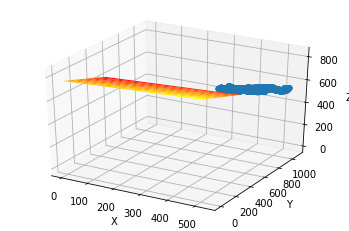

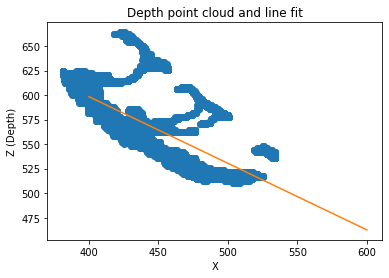

In [496]:
main()